# Dependencies

In [ ]:
# I suggest to install them directly on terminal
!pip install tensorflow==2.3.4
!pip install tensorflow-io

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import tensorflow_io as tfio
from keras.callbacks import EarlyStopping
from PIL import Image

2025-10-21 18:48:36.205734: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 18:48:36.207962: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-21 18:48:36.253686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-21 18:48:36.254376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-21 18:48:37.165366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# From-Scratch

## Splitting

In [2]:
train_directory = 'train/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123,
    validation_split=0.2, subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 2477 files belonging to 2 classes.
Using 495 files for validation.
['0', '1']


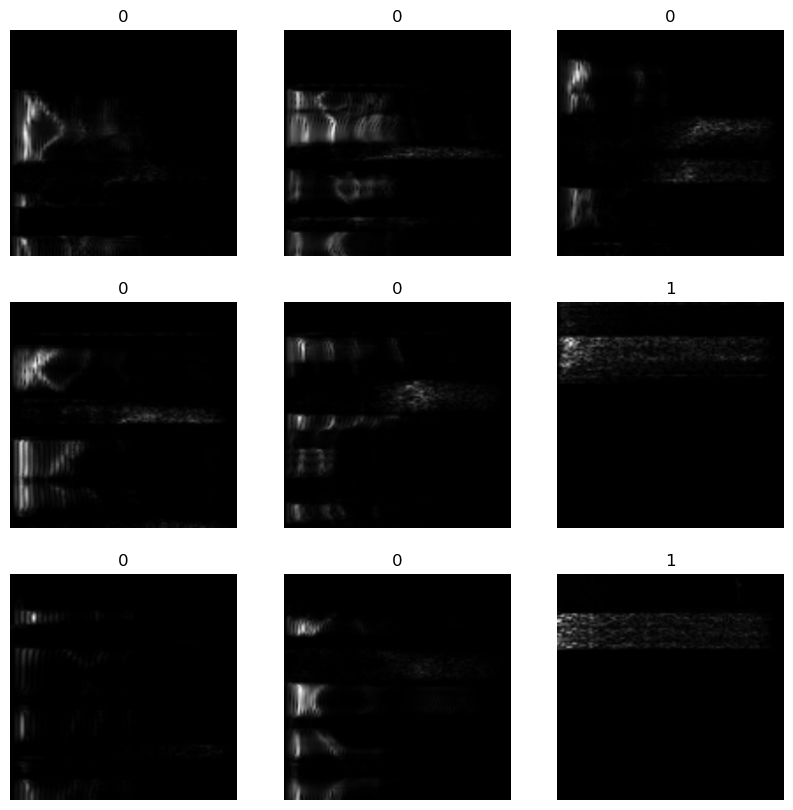

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
num_classes = 2
img_height = 256
img_width = 256

early_stopping = EarlyStopping(
    monitor="accuracy",
    restore_best_weights=True,
    start_from_epoch=0,
)

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax'),

])

In [5]:
learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [7]:
epochs = 15

history = model.fit(train_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15


/home/dhekmass/anaconda3/envs/msd/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 5s 262ms/step - loss: 0.1958 - accuracy: 0.9152
Epoch 2/15
16/16 [==============================] - 4s 255ms/step - loss: 0.0054 - accuracy: 0.9980
Epoch 3/15
16/16 [==============================] - 5s 339ms/step - loss: 9.1649e-04 - accuracy: 1.0000
Epoch 4/15
16/16 [==============================] - 6s 367ms/step - loss: 5.1778e-04 - accuracy: 1.0000


## Testing

In [8]:
test_directory = 'test/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(test_directory)

In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 3354 files belonging to 2 classes.
1/1 [==============================] - 0s 250ms/step
Number correct: 3344 out of 3354
Accuracy 0.9970184853905785
Mean Confidence Score 0.9985552292959137


## Inference

In [10]:
inference_directory = 'inference/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(inference_directory)

In [11]:
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inference_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(inference_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 6 files belonging to 2 classes.
1/1 [==============================] - 0s 49ms/step
Number correct: 6 out of 6
Accuracy 1.0
Mean Confidence Score 0.929185301065445


## Save Model

In [12]:
model.save('from_scratch.keras')

# 2. Fine-Tuning (Combined with Crowd Sound)

## Splitting

In [13]:
train_directory = 'train_2/'

def validate_images(directory):
    global counter
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(train_directory)

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123,
    validation_split=0.2, subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 780 files belonging to 1 classes.
Using 156 files for validation.
['1']


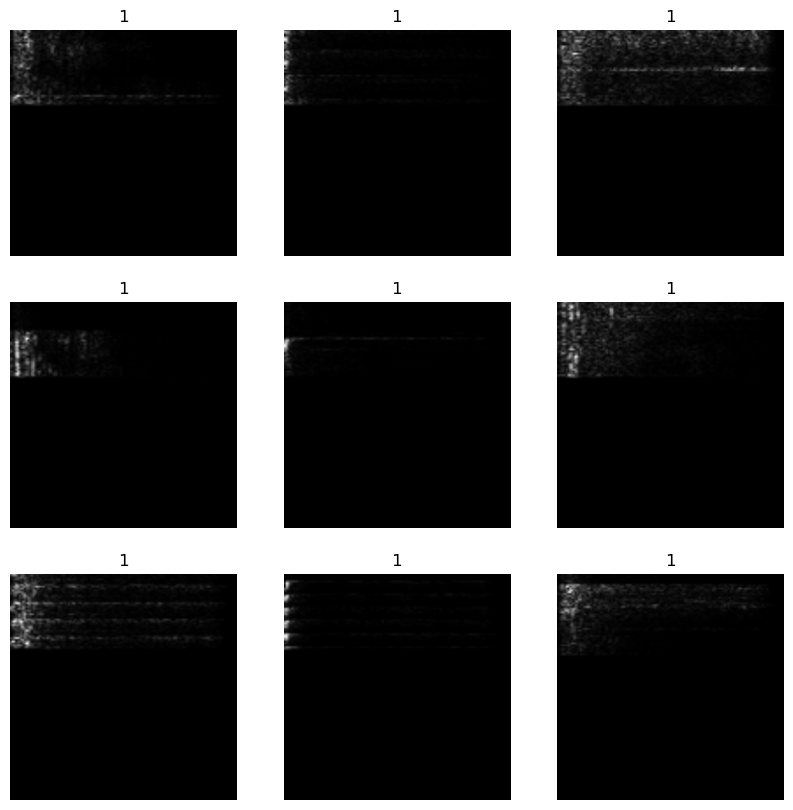

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Modelling

In [16]:
epochs = 15

crowded_model = tf.keras.models.load_model('from_scratch.keras')
history = crowded_model.fit(train_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15
5/5 [==============================] - 2s 289ms/step - loss: 2.3378 - accuracy: 0.7949
Epoch 2/15
5/5 [==============================] - 2s 298ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/15
5/5 [==============================] - 1s 279ms/step - loss: 0.0000e+00 - accuracy: 1.0000


## Testing

In [17]:
test_directory = 'test/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(test_directory)

In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = crowded_model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 3354 files belonging to 2 classes.
1/1 [==============================] - 0s 194ms/step
Number correct: 3354 out of 3354
Accuracy 1.0
Mean Confidence Score 1.0


## Inference

In [19]:
inference_directory = 'inference/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(inference_directory)

In [20]:
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inference_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(inference_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = crowded_model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 6 files belonging to 2 classes.
1/1 [==============================] - 0s 57ms/step
Number correct: 1 out of 6
Accuracy 0.16666666666666666
Mean Confidence Score 1.0


## Save Model

In [21]:
crowded_model.save('crowded_model.keras')

# 3. Fine-Tuning (Energy Modification)

## Splitting

In [22]:
train_directory = 'train_3/'

def validate_images(directory):
    global counter
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(train_directory)

In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123,
    validation_split=0.2, subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 2475 files belonging to 2 classes.
Using 495 files for validation.
['0', '1']


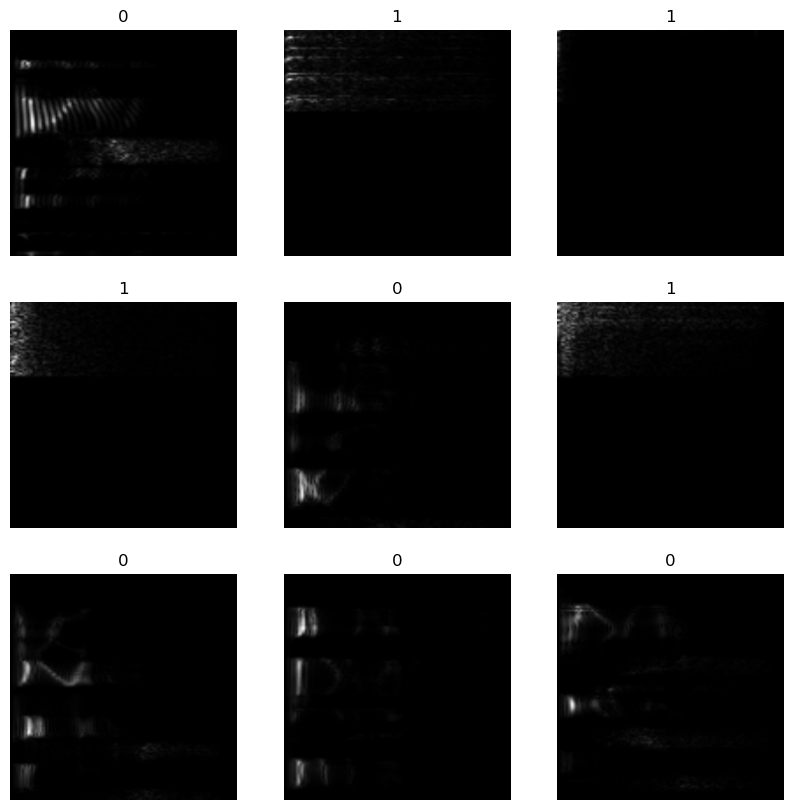

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
epochs = 15

energy_model = tf.keras.models.load_model('from_scratch.keras')
history = energy_model.fit(train_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15
16/16 [==============================] - 9s 257ms/step - loss: 8.3990e-04 - accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 4s 252ms/step - loss: 5.0078e-04 - accuracy: 1.0000


## Testing

In [26]:
test_directory = 'test/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(test_directory)

In [27]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 3354 files belonging to 2 classes.
1/1 [==============================] - 0s 111ms/step
Number correct: 3344 out of 3354
Accuracy 0.9970184853905785
Mean Confidence Score 0.9985552292959137


## Inference

In [28]:
inference_directory = 'inference/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(inference_directory)

In [29]:
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inference_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(inference_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = energy_model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 6 files belonging to 2 classes.
1/1 [==============================] - 0s 78ms/step
Number correct: 6 out of 6
Accuracy 1.0
Mean Confidence Score 0.9197883903980255


## Save Model

In [30]:
energy_model.save('energy_model.keras')